In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
trips = pd.read_csv('tripdata_2019-05.csv')

In [3]:
trips

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-05-01 00:14:50,2019-05-01 00:16:48,1,0.00,1,N,145,145,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
1,1,2019-05-01 00:35:54,2019-05-01 00:37:27,1,1.50,1,N,145,145,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
2,1,2019-05-01 00:37:45,2019-05-01 00:37:49,1,1.50,1,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80,0.0
3,1,2019-05-01 00:44:57,2019-05-01 00:50:11,1,0.70,1,N,161,161,2,5.0,3.0,0.5,0.00,0.0,0.3,8.80,2.5
4,1,2019-05-01 00:59:48,2019-05-01 01:10:22,1,2.00,1,N,163,141,1,9.5,3.0,0.5,2.00,0.0,0.3,15.30,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7565256,2,2019-05-31 23:22:08,2019-05-31 23:58:35,3,15.69,1,N,231,153,1,46.5,0.5,0.5,12.58,0.0,0.3,62.88,2.5
7565257,2,2019-05-31 23:10:12,2019-05-31 23:17:56,1,1.42,1,N,262,237,1,7.5,0.5,0.5,2.82,0.0,0.3,14.12,2.5
7565258,2,2019-05-31 23:38:07,2019-06-01 00:47:30,1,9.39,1,N,170,36,2,42.0,0.5,0.5,0.00,0.0,0.3,45.80,2.5
7565259,2,2019-05-31 23:59:08,2019-06-01 00:00:21,1,0.00,1,N,193,193,1,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0


Заменим невалидные значения в колонках:

кол-во пассажиров установим в 1;

RatecodeId в 5(договорная оплата);

store_and_fwd_flag в N(передача данных осуществлялась из памяти средства передвижения, т.е. прямое подключение к серверу отсутствовало);

payment_type в 5(Unknown payment type);

In [4]:
trips.passenger_count = trips.passenger_count.fillna(1)
trips.RatecodeID = trips.RatecodeID.fillna(5)
trips.store_and_fwd_flag = trips.store_and_fwd_flag.fillna('N')
trips.payment_type = trips.payment_type.fillna(5)

Посмотрим на количество колонок, в которых встречаются данные со значением Nan.

In [5]:
for el in trips.columns:
    print(el, trips[el].isna().sum())

VendorID 0
tpep_pickup_datetime 0
tpep_dropoff_datetime 0
passenger_count 0
trip_distance 0
RatecodeID 0
store_and_fwd_flag 0
PULocationID 0
DOLocationID 0
payment_type 0
fare_amount 0
extra 0
mta_tax 0
tip_amount 0
tolls_amount 0
improvement_surcharge 0
total_amount 0
congestion_surcharge 0


In [6]:
trips

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-05-01 00:14:50,2019-05-01 00:16:48,1,0.00,1,N,145,145,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
1,1,2019-05-01 00:35:54,2019-05-01 00:37:27,1,1.50,1,N,145,145,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
2,1,2019-05-01 00:37:45,2019-05-01 00:37:49,1,1.50,1,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80,0.0
3,1,2019-05-01 00:44:57,2019-05-01 00:50:11,1,0.70,1,N,161,161,2,5.0,3.0,0.5,0.00,0.0,0.3,8.80,2.5
4,1,2019-05-01 00:59:48,2019-05-01 01:10:22,1,2.00,1,N,163,141,1,9.5,3.0,0.5,2.00,0.0,0.3,15.30,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7565256,2,2019-05-31 23:22:08,2019-05-31 23:58:35,3,15.69,1,N,231,153,1,46.5,0.5,0.5,12.58,0.0,0.3,62.88,2.5
7565257,2,2019-05-31 23:10:12,2019-05-31 23:17:56,1,1.42,1,N,262,237,1,7.5,0.5,0.5,2.82,0.0,0.3,14.12,2.5
7565258,2,2019-05-31 23:38:07,2019-06-01 00:47:30,1,9.39,1,N,170,36,2,42.0,0.5,0.5,0.00,0.0,0.3,45.80,2.5
7565259,2,2019-05-31 23:59:08,2019-06-01 00:00:21,1,0.00,1,N,193,193,1,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0


Преобразуем формат ячеек с временем для удобства.

In [7]:
trips['tpep_pickup_datetime'] = pd.to_datetime(trips.tpep_pickup_datetime)
trips['tpep_dropoff_datetime'] = pd.to_datetime(trips.tpep_dropoff_datetime)

Введём новые колонки: с датой начала поездки, с часом начала и конца, с днём недели начала поездки и с временем продолжительности поездки(день конца поездки игнорируем, т.к. почти все поездки будут в промежутке одного дня).

In [8]:
trips['trip_pickup_day'] = trips.tpep_pickup_datetime.dt.day
trips['week_day'] = trips.tpep_pickup_datetime.dt.dayofweek
trips['trip_pickup_hour'] = trips.tpep_pickup_datetime.dt.hour
trips['trip_dropoff_hour'] = trips.tpep_dropoff_datetime.dt.hour
trips['trip_duration'] = trips.tpep_dropoff_datetime - trips.tpep_pickup_datetime
trips['trip_duration_secs'] = trips.trip_duration.dt.seconds

In [9]:
trips

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_pickup_day,week_day,trip_pickup_hour,trip_dropoff_hour,trip_duration,trip_duration_secs
0,1,2019-05-01 00:14:50,2019-05-01 00:16:48,1,0.00,1,N,145,145,2,...,0.0,0.3,4.30,0.0,1,2,0,0,00:01:58,118
1,1,2019-05-01 00:35:54,2019-05-01 00:37:27,1,1.50,1,N,145,145,2,...,0.0,0.3,4.30,0.0,1,2,0,0,00:01:33,93
2,1,2019-05-01 00:37:45,2019-05-01 00:37:49,1,1.50,1,N,145,145,2,...,0.0,0.3,3.80,0.0,1,2,0,0,00:00:04,4
3,1,2019-05-01 00:44:57,2019-05-01 00:50:11,1,0.70,1,N,161,161,2,...,0.0,0.3,8.80,2.5,1,2,0,0,00:05:14,314
4,1,2019-05-01 00:59:48,2019-05-01 01:10:22,1,2.00,1,N,163,141,1,...,0.0,0.3,15.30,2.5,1,2,0,1,00:10:34,634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7565256,2,2019-05-31 23:22:08,2019-05-31 23:58:35,3,15.69,1,N,231,153,1,...,0.0,0.3,62.88,2.5,31,4,23,23,00:36:27,2187
7565257,2,2019-05-31 23:10:12,2019-05-31 23:17:56,1,1.42,1,N,262,237,1,...,0.0,0.3,14.12,2.5,31,4,23,23,00:07:44,464
7565258,2,2019-05-31 23:38:07,2019-06-01 00:47:30,1,9.39,1,N,170,36,2,...,0.0,0.3,45.80,2.5,31,4,23,0,01:09:23,4163
7565259,2,2019-05-31 23:59:08,2019-06-01 00:00:21,1,0.00,1,N,193,193,1,...,0.0,0.0,0.00,0.0,31,4,23,0,00:01:13,73


Построим гистограммы по дню поездки, где понедельник = 0, воскресенье = 6.

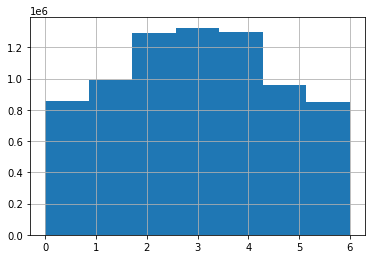

In [10]:
trips.week_day.hist(bins=7)

Посмотрим на распределение по каждому дню недели.

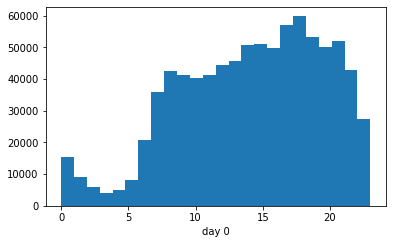

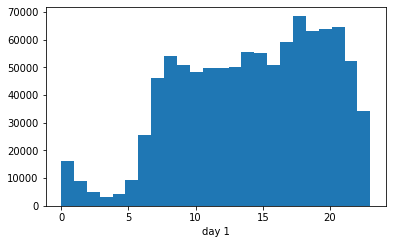

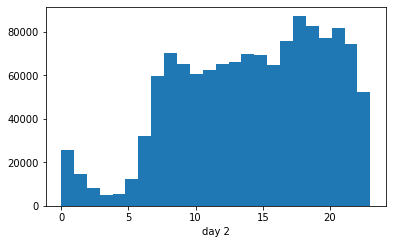

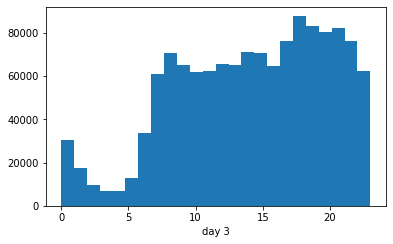

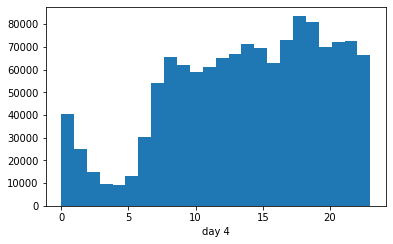

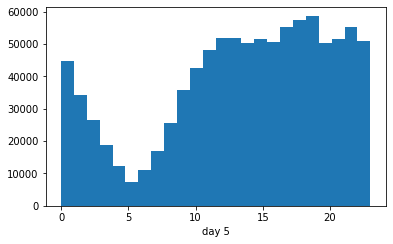

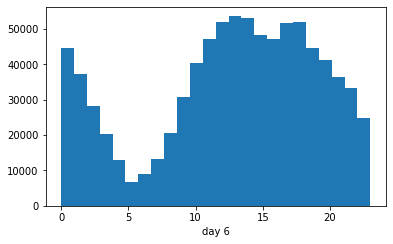

In [11]:
for i in range(7):
    plt.figure(figsize=(50,30))
    plt.subplot(7, 7, i + 1)
    plt.xlabel('day ' + str(i))
    plt.hist(trips[trips.week_day == i].trip_pickup_hour, bins=24)

По дате начала поездки.

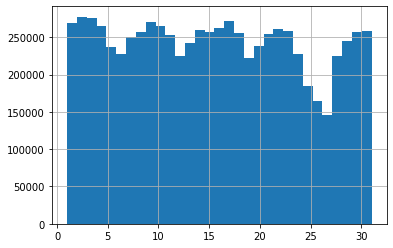

In [12]:
trips.trip_pickup_day.hist(bins=31)

По часу начала и конца.

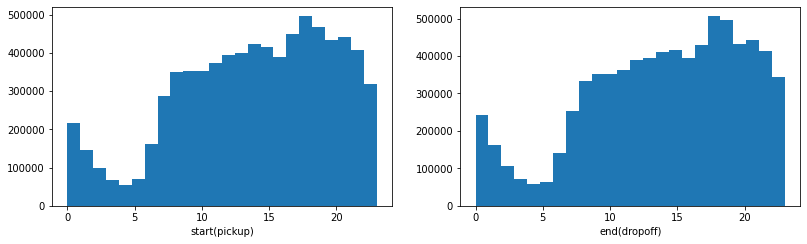

In [28]:
plt.figure(figsize=(50, 30))
plt.subplot(7, 7, 1)
plt.xlabel('start(pickup)')
arr_val1 = plt.hist(trips.trip_pickup_hour, bins=24)
plt.subplot(7, 7, 2)
plt.xlabel('end(dropoff)')
arr_val2 = plt.hist(trips.trip_dropoff_hour, bins=24)